In [21]:
import pyarrow.dataset as ds
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch

In [22]:
def dataset_spitter(farm_name, data_category, turbine_name=None):
    """
    Returns a dataframe and the valid categories for which we consider the turbine data
    """
    base_path = Path().resolve().parent
    data_category = str(data_category).upper()

    if data_category == 'SCADA_DATA':
        dataset_path = base_path / farm_name / data_category
        if turbine_name:
            dataset_path = dataset_path / turbine_name
        dataset = ds.dataset(dataset_path, format='parquet')
        return dataset.to_table().to_pandas()

    elif data_category == 'STATUS_DATA':
        dataset_path = base_path / farm_name / data_category
        if turbine_name:
            dataset_path = dataset_path / turbine_name
        dataset = ds.dataset(dataset_path, format='parquet')
        df = dataset.to_table().to_pandas()
        df.columns = df.iloc[0]
        df = df.iloc[1:].reset_index(drop=True)
        return df

    else:
        raise ValueError("data_category must be 'SCADA_DATA' or 'STATUS_DATA'.")


In [37]:
Path().resolve()

PosixPath('/Users/raul/Documents/GitHub/Zephyrus/notebooks')

In [23]:
def build_clean_events(
    df_status,
    start_col="Timestamp start",
    end_col="Timestamp end",
    dur_col_alt="Duration_hours",     
    dur_text_col="Duration",           
    iec_col="IEC category",
    valid_categories=("Out of Electrical Specification", "Full Performance"),
    min_valid_hours=0,
):
    """
    Returns a DataFrame with exactly:
      start, end, duration_hours, is_valid, is_invalid

    Steps:
      - coerce timestamps
      - derive duration_hours (prefer textual 'Duration' -> timedelta; else 'Duration_hours'; else end-start)
      - synthesize missing end from start + duration_hours
      - drop bad spans
      - compute validity (IEC category in valid_categories AND duration_hours >= min_valid_hours)
      - remove overlapping intervals (keep earliest)
    """
    need = {start_col, iec_col}
    if not need.issubset(df_status.columns):
        missing = ", ".join(sorted(need - set(df_status.columns)))
        raise KeyError(f"df_status missing required columns: {missing}")

    df = df_status.copy()

    df[start_col] = pd.to_datetime(df[start_col], errors="coerce")
    if end_col in df.columns:
        df[end_col] = pd.to_datetime(df.get(end_col), errors="coerce")
    else:
        df[end_col] = pd.NaT

    if dur_text_col in df.columns:
        td = pd.to_timedelta(df[dur_text_col], errors="coerce")
        df["duration_hours"] = td / pd.Timedelta(hours=1)
    elif dur_col_alt in df.columns:
        df["duration_hours"] = pd.to_numeric(df[dur_col_alt], errors="coerce")
    else:
        df["duration_hours"] = pd.NA

    need_end = df[end_col].isna() & df[start_col].notna() & pd.notna(df["duration_hours"])
    if need_end.any():
        df.loc[need_end, end_col] = df.loc[need_end, start_col] + pd.to_timedelta(
            df.loc[need_end, "duration_hours"], unit="h"
        )
    still_missing = pd.isna(df["duration_hours"]) & df[end_col].notna() & df[start_col].notna()
    if still_missing.any():
        span = (df.loc[still_missing, end_col] - df.loc[still_missing, start_col]).dt.total_seconds() / 3600.0
        df.loc[still_missing, "duration_hours"] = span


    df = df.dropna(subset=[start_col, end_col, "duration_hours"]).copy()
    df = df.loc[df[end_col] > df[start_col]].copy()

    if df.empty:
        return pd.DataFrame(columns=["start", "end", "duration_hours", "is_valid", "is_invalid"])

    valid_set = set(valid_categories)
    s = df[iec_col].astype("string").str.strip()
    df["is_valid"] = s.isin(valid_set) & (df["duration_hours"] >= float(min_valid_hours))
    df["is_valid"] = df["is_valid"].fillna(False)
    df["is_invalid"] = ~df["is_valid"]

    df = df.sort_values(start_col).reset_index(drop=True)
    kept = []
    last_end = None
    for _, r in df.iterrows():
        s_ts, e_ts = r[start_col], r[end_col]
        if (last_end is None) or (s_ts >= last_end):
            kept.append((s_ts, e_ts, float(r["duration_hours"]), bool(r["is_valid"]), bool(r["is_invalid"])))
            last_end = e_ts

    out = pd.DataFrame(kept, columns=["start", "end", "duration_hours", "is_valid", "is_invalid"])
    return out.reset_index(drop=True)


In [24]:
df = dataset_spitter('penmanshiel', 'STATUS_DATA')
df_status = build_clean_events(df)

In [25]:
def plot_weekly_valid_invalid_counts_from_clean(
    df_clean,
    *,
    min_hours=0.0,         
    return_data=False,
    legend_table=True,
    legend_loc="upper right",
):
    """
    Input: cleaned, non-overlapping events with columns:
      ['start','end','duration_hours','is_valid','is_invalid'].
    Bars show EVENT COUNTS; legend stats show HOURS.
    """
    req = {"start","end","duration_hours","is_valid"}
    if not req.issubset(df_clean.columns):
        missing = ", ".join(sorted(req - set(df_clean.columns)))
        raise KeyError(f"df_clean is missing: {missing}")

    df = df_clean.copy()
    df["start"] = pd.to_datetime(df["start"], errors="coerce")
    df["end"]   = pd.to_datetime(df["end"],   errors="coerce")

    df = df.dropna(subset=["start","end","duration_hours"])
    df = df.loc[df["end"] > df["start"]]
    if min_hours is not None and min_hours > 0:
        df = df.loc[df["duration_hours"] >= float(min_hours)]
    if df.empty:
        if return_data:
            return pd.DataFrame(columns=["week_start","valid","invalid"])
        return None

    df = df.reset_index(drop=True)
    df["_event_id"] = df.index.astype(str)

    alloc_events = []
    alloc_hours  = []
    for s, e, v, eid, hrs in zip(df["start"], df["end"], df["is_valid"], df["_event_id"], df["duration_hours"]):
        wk = s.to_period("W-MON").start_time
        while wk < e:
            wk_next = wk + pd.offsets.Week(weekday=0)
            seg_start = max(s, wk)
            seg_end   = min(e, wk_next)
            if seg_end > seg_start:
                seg_hours = (seg_end - seg_start).total_seconds() / 3600.0
                alloc_events.append((wk, bool(v), eid))
                alloc_hours.append((wk, bool(v), seg_hours))
            wk = wk_next

    if not alloc_events:
        if return_data:
            return pd.DataFrame(columns=["week_start","valid","invalid"])
        return None

    alloc_events_df = pd.DataFrame(alloc_events, columns=["week_start","is_valid","_event_id"])
    agg_counts = (alloc_events_df.groupby(["week_start","is_valid"])["_event_id"]
                  .nunique()
                  .unstack("is_valid", fill_value=0)
                  .rename(columns={True:"valid", False:"invalid"})
                  .reset_index()
                  .sort_values("week_start")
                  .reset_index(drop=True))

    alloc_hours_df = pd.DataFrame(alloc_hours, columns=["week_start","is_valid","hours"])
    agg_hours = (alloc_hours_df.groupby(["week_start","is_valid"])["hours"]
                 .sum()
                 .unstack("is_valid", fill_value=0.0)
                 .rename(columns={True:"valid", False:"invalid"})
                 .reset_index())

    agg_counts["year"] = agg_counts["week_start"].dt.year
    valid_color, invalid_color = "tab:blue", "grey"
    valid_alpha, invalid_alpha = 1.0, 0.3

    for y in sorted(agg_counts["year"].unique()):
        g_counts = agg_counts.loc[agg_counts["year"] == y, ["week_start","valid","invalid"]].copy()
        g_hours  = agg_hours.loc[agg_hours["week_start"].dt.year == y, ["week_start","valid","invalid"]].copy()
        year_start = pd.Timestamp(y, 1, 1).to_period("W-MON").start_time
        year_end   = pd.Timestamp(y, 12, 31).to_period("W-MON").start_time
        full_weeks = pd.date_range(start=year_start, end=year_end, freq="W-MON")

        g_counts = (g_counts.set_index("week_start")
                              .reindex(full_weeks, fill_value=0)
                              .rename_axis("week_start")
                              .reset_index())
        g_hours = (g_hours.set_index("week_start")
                            .reindex(full_weeks, fill_value=0.0)
                            .rename_axis("week_start")
                            .reset_index())
        sum_valid = float(g_hours["valid"].sum())
        sum_invalid = float(g_hours["invalid"].sum())
        mean_valid = float(g_hours["valid"].mean())
        mean_invalid = float(g_hours["invalid"].mean())

        fig, ax = plt.subplots(figsize=(24, 8))
        ax.bar(g_counts["week_start"], g_counts["valid"], width=5, color=valid_color, alpha=valid_alpha)
        ax.bar(g_counts["week_start"], g_counts["invalid"], bottom=g_counts["valid"], width=5,
               color=invalid_color, alpha=invalid_alpha)

        if legend_table:
            mono_font = {"family": "DejaVu Sans", "size": 18}
            header = f"{'':8}{'Mean (h)':>12} | {'Total (h)':>12}"
            valid_label = f"{'valid':8}{mean_valid:12.2f} | {sum_valid:12.1f}"
            invalid_label = f"{'invalid':8}{mean_invalid:12.2f} | {sum_invalid:12.1f}"
            header_patch = Patch(facecolor="white", edgecolor="white", alpha=0, label=header)
            valid_patch = Patch(facecolor=valid_color, alpha=valid_alpha)
            invalid_patch = Patch(facecolor=invalid_color, alpha=invalid_alpha)
            ax.legend([header_patch, valid_patch, invalid_patch],
                      [header, valid_label, invalid_label],
                      loc=legend_loc, prop=mono_font, frameon=True, framealpha=0.5,
                      facecolor="white", edgecolor="black", fancybox=False, borderpad=0.5)

        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
        ax.set_xlabel("Month", fontsize=20)
        ax.set_ylabel("Events per week", fontsize=20)
        ax.set_title(f"Weekly Events (counts) — Hours stats in legend — {y}", fontsize=20)
        ax.tick_params(axis="x", labelsize=20)  # X-axis numbers
        ax.tick_params(axis="y", labelsize=20)  # Y-axis numbers

        plt.tight_layout()
        plt.show()

    return agg_counts.drop(columns=["year"]) if return_data else None


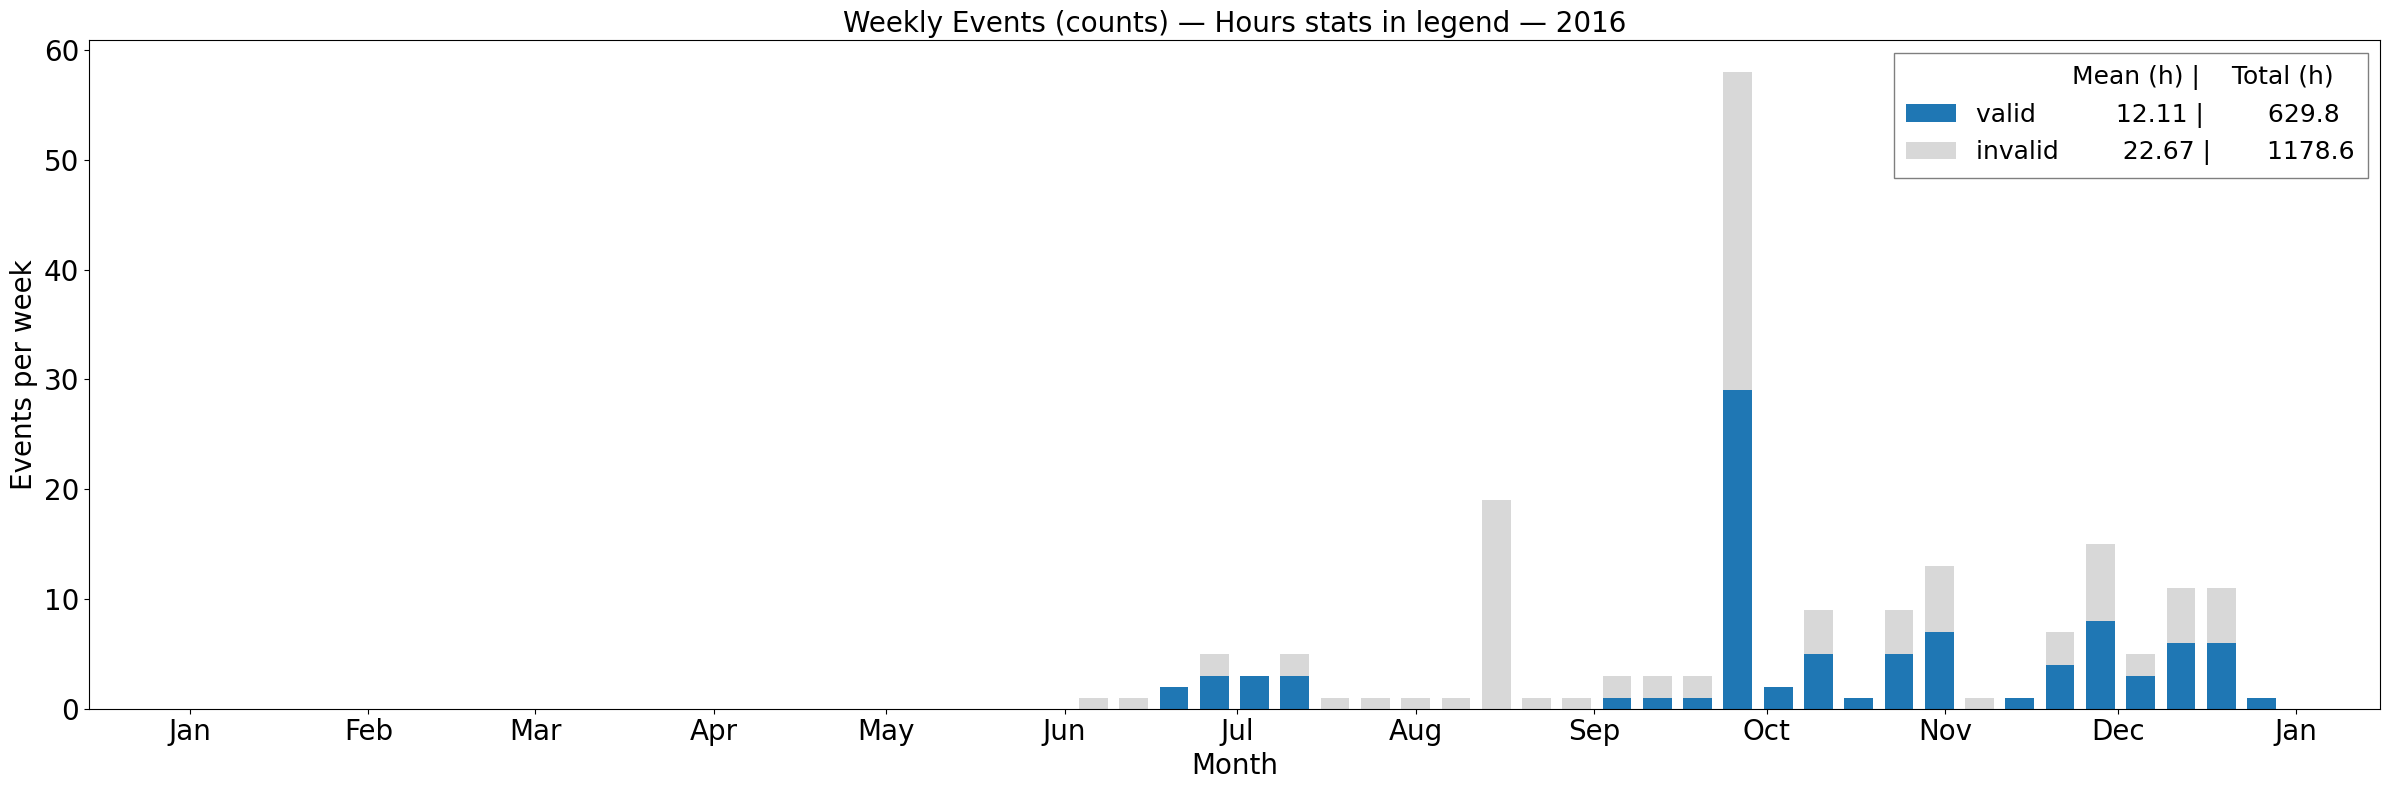

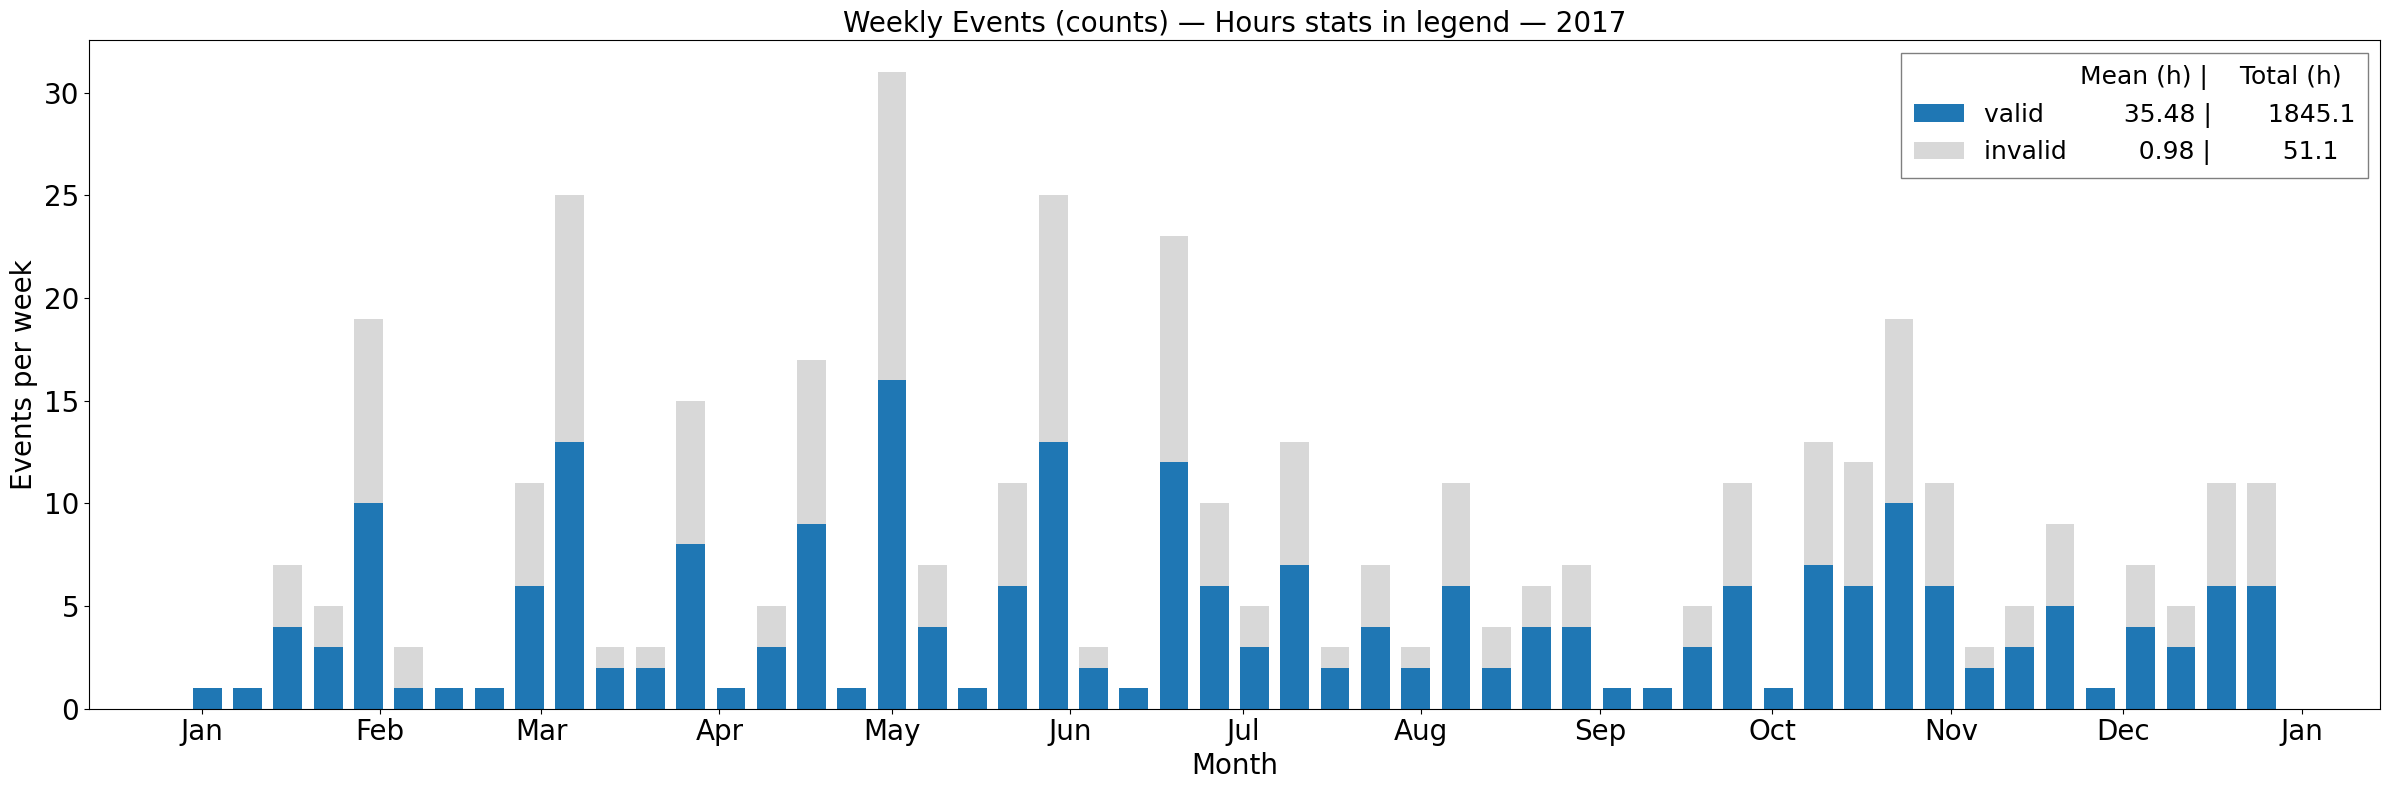

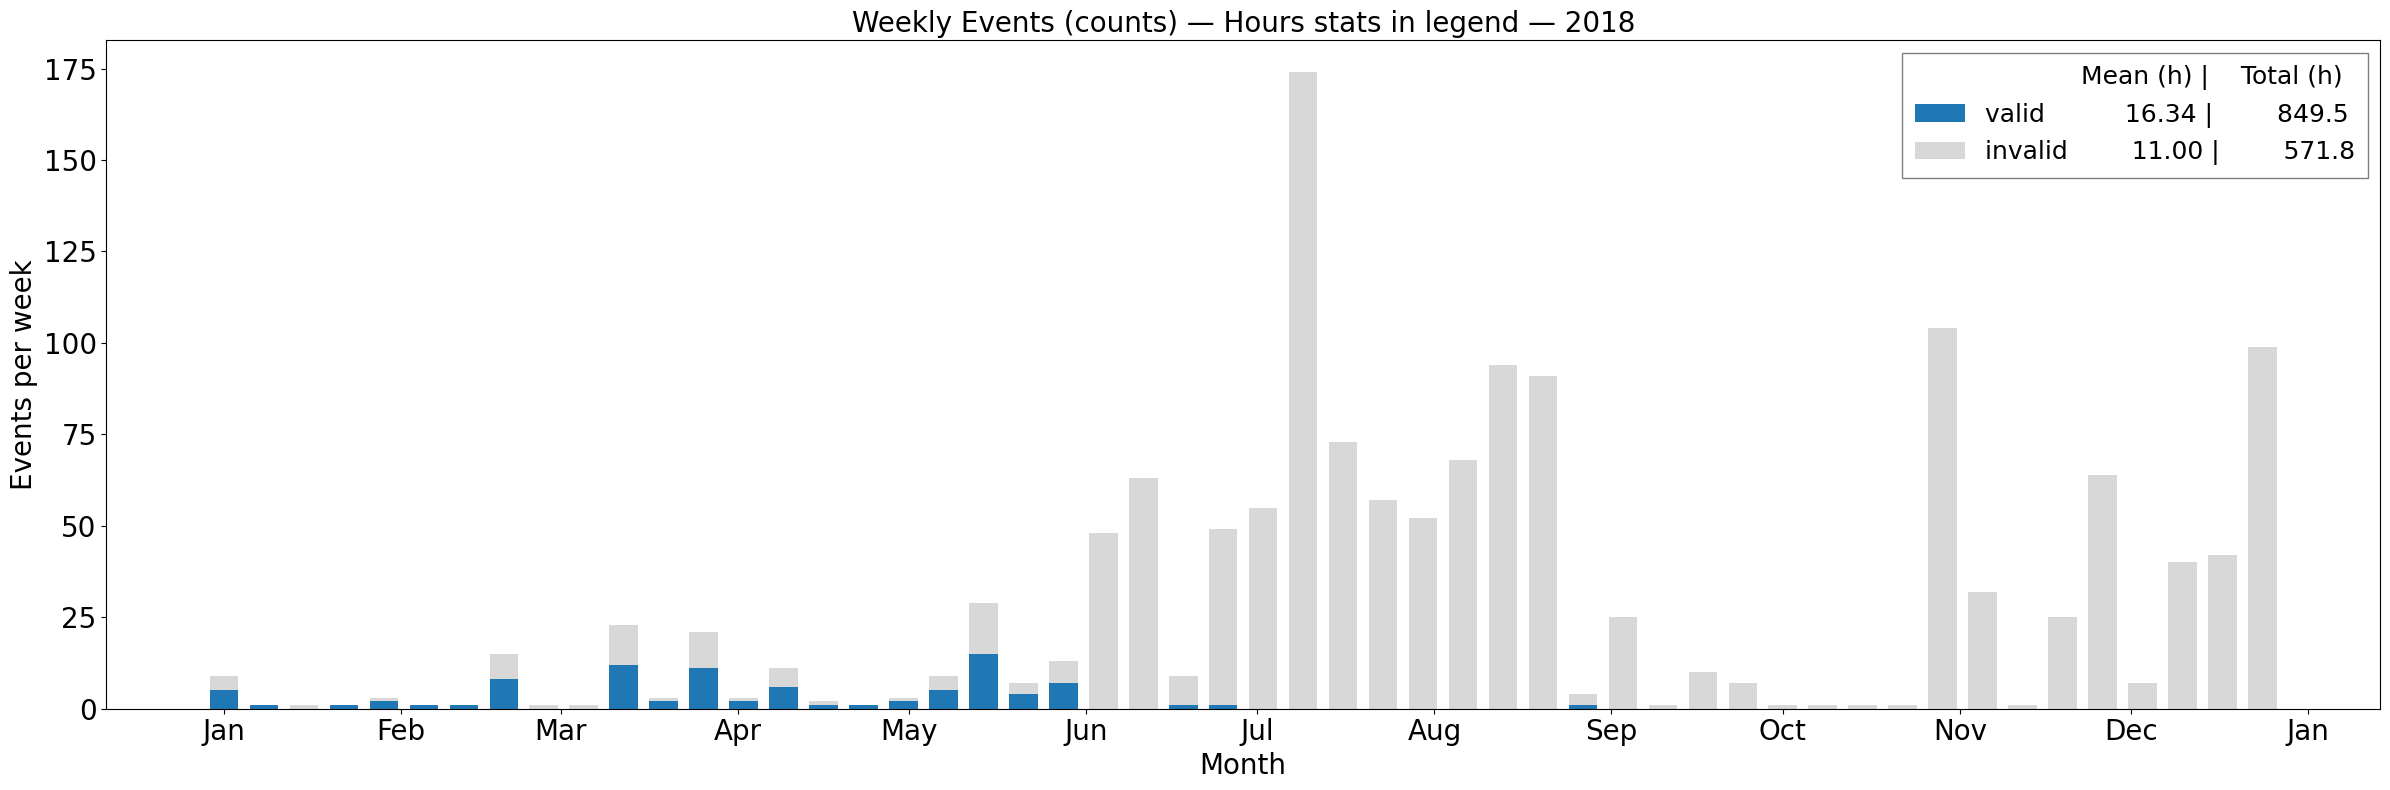

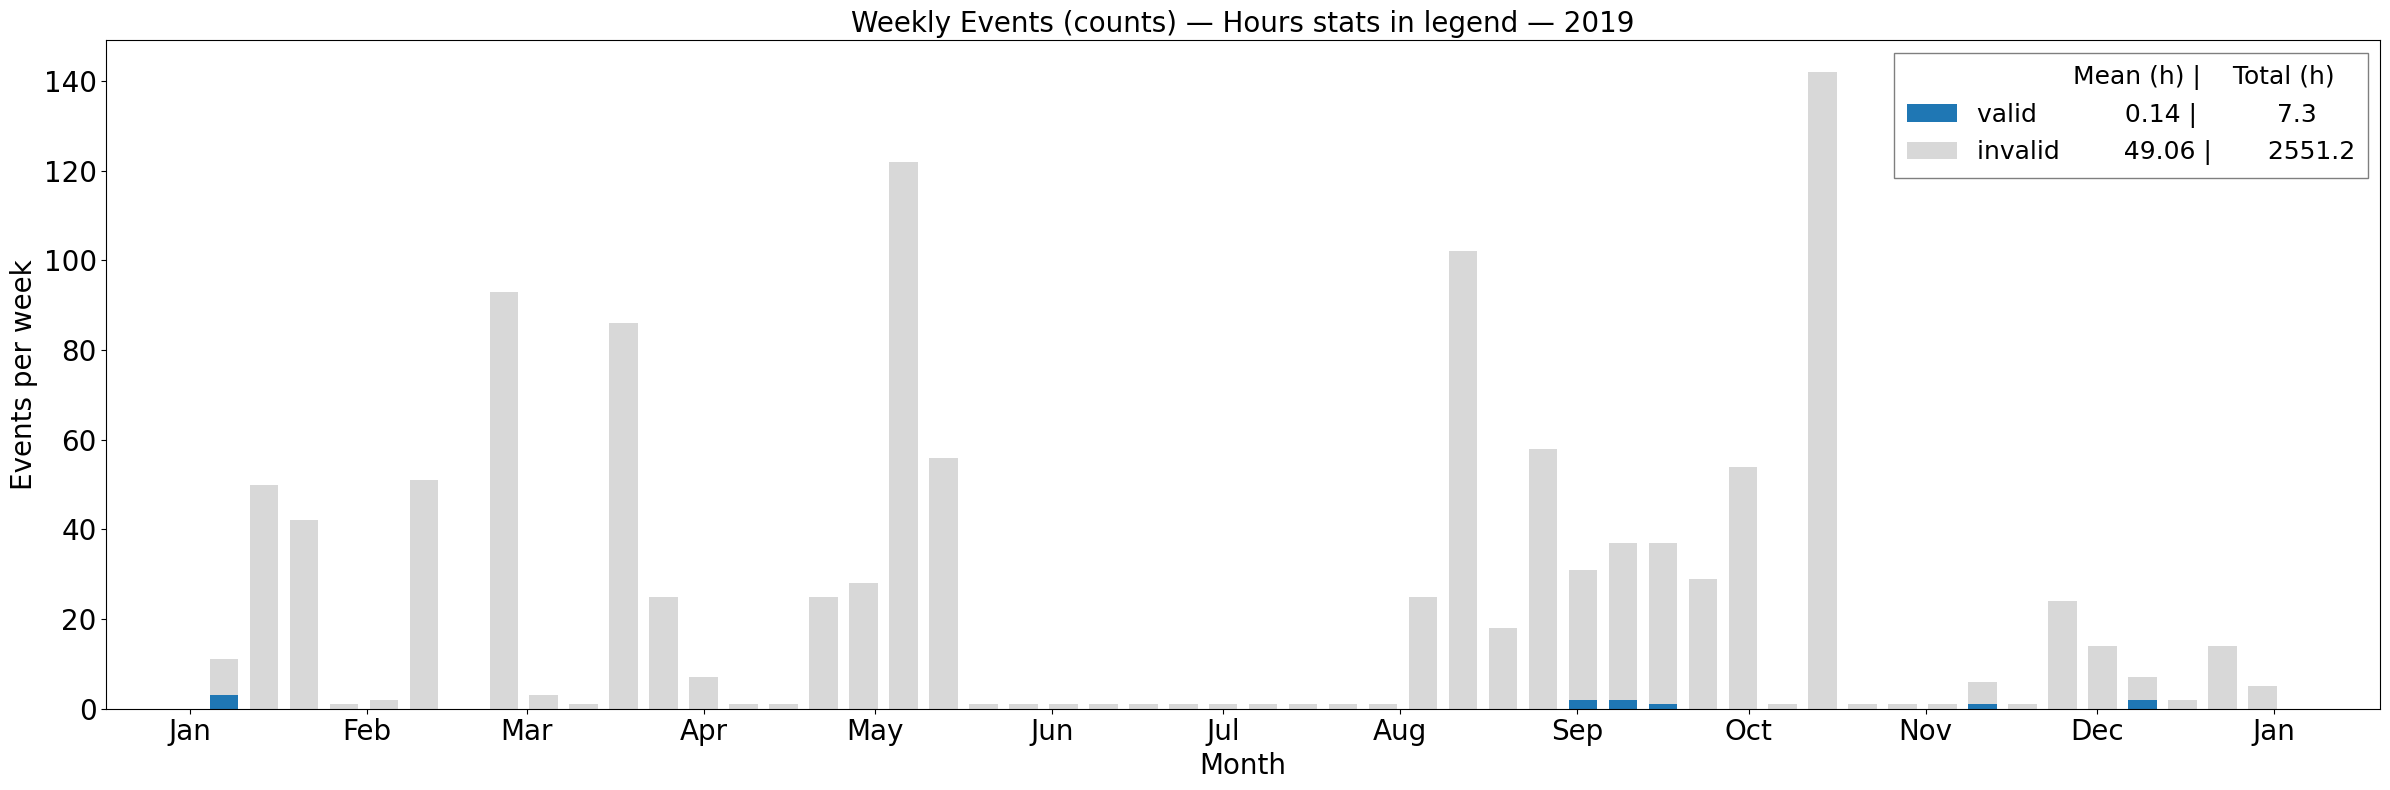

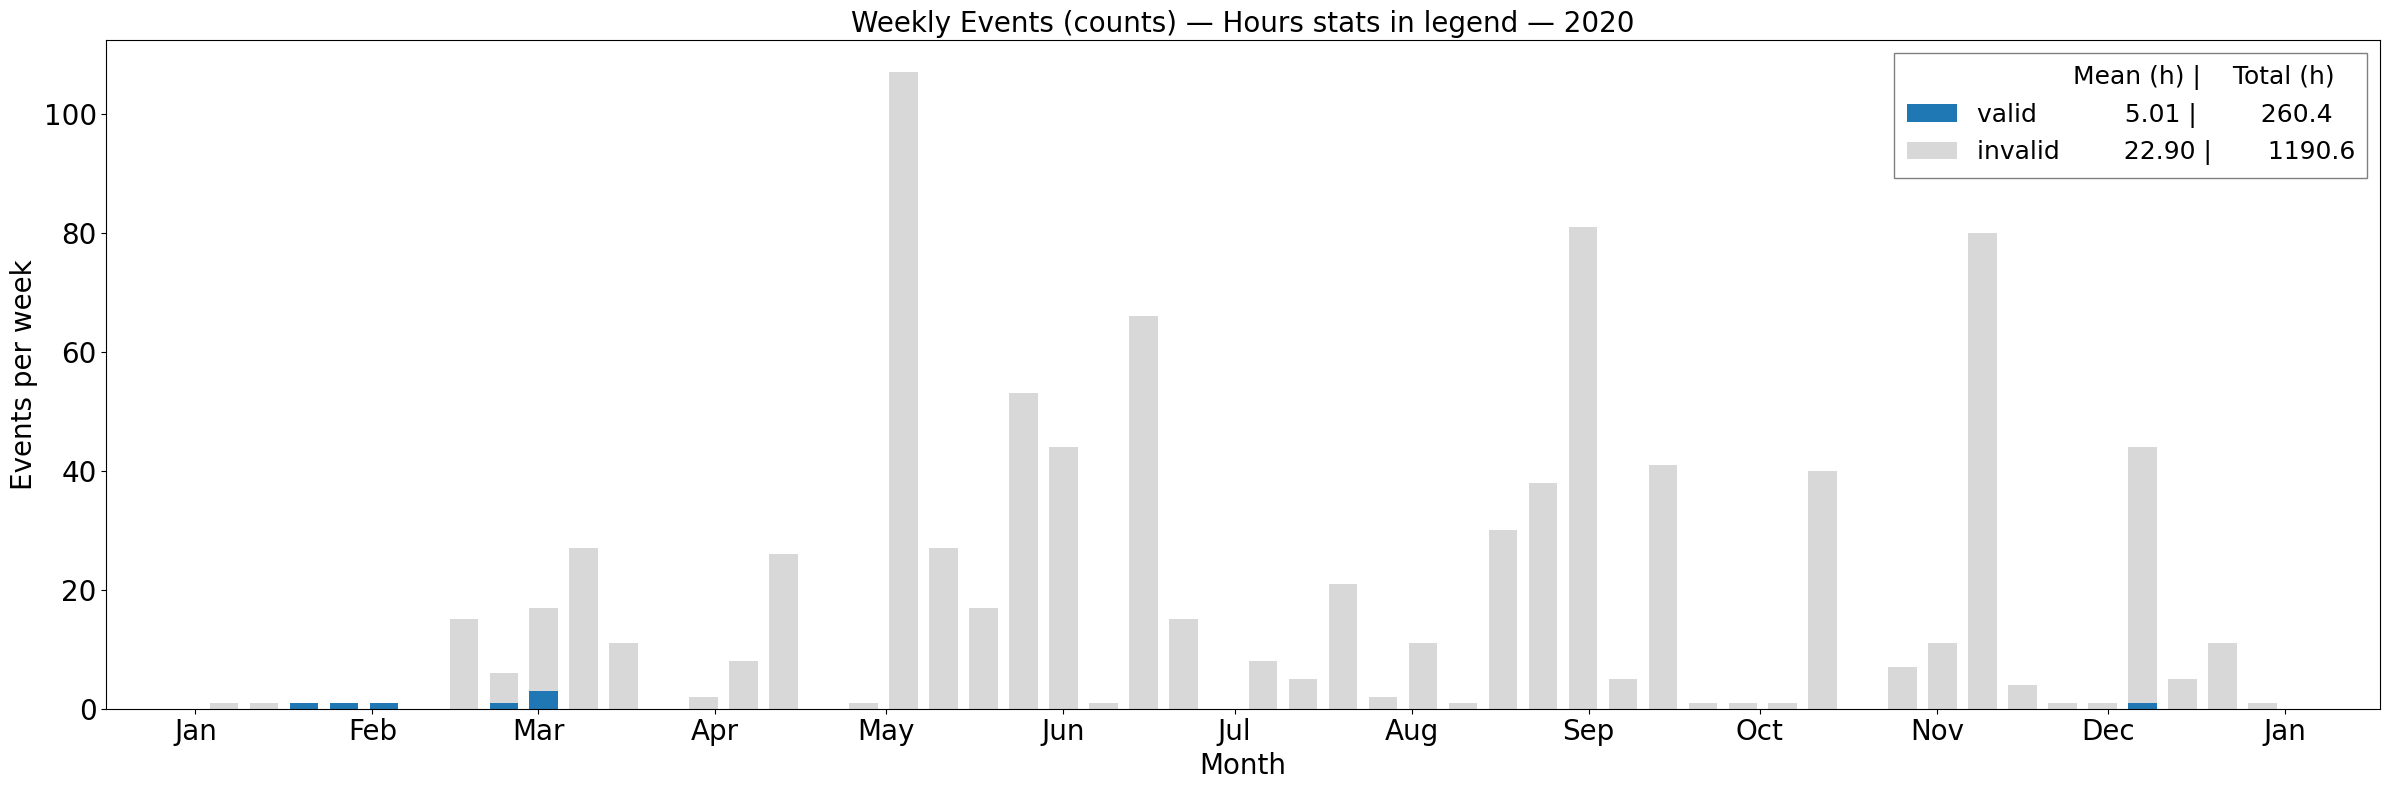

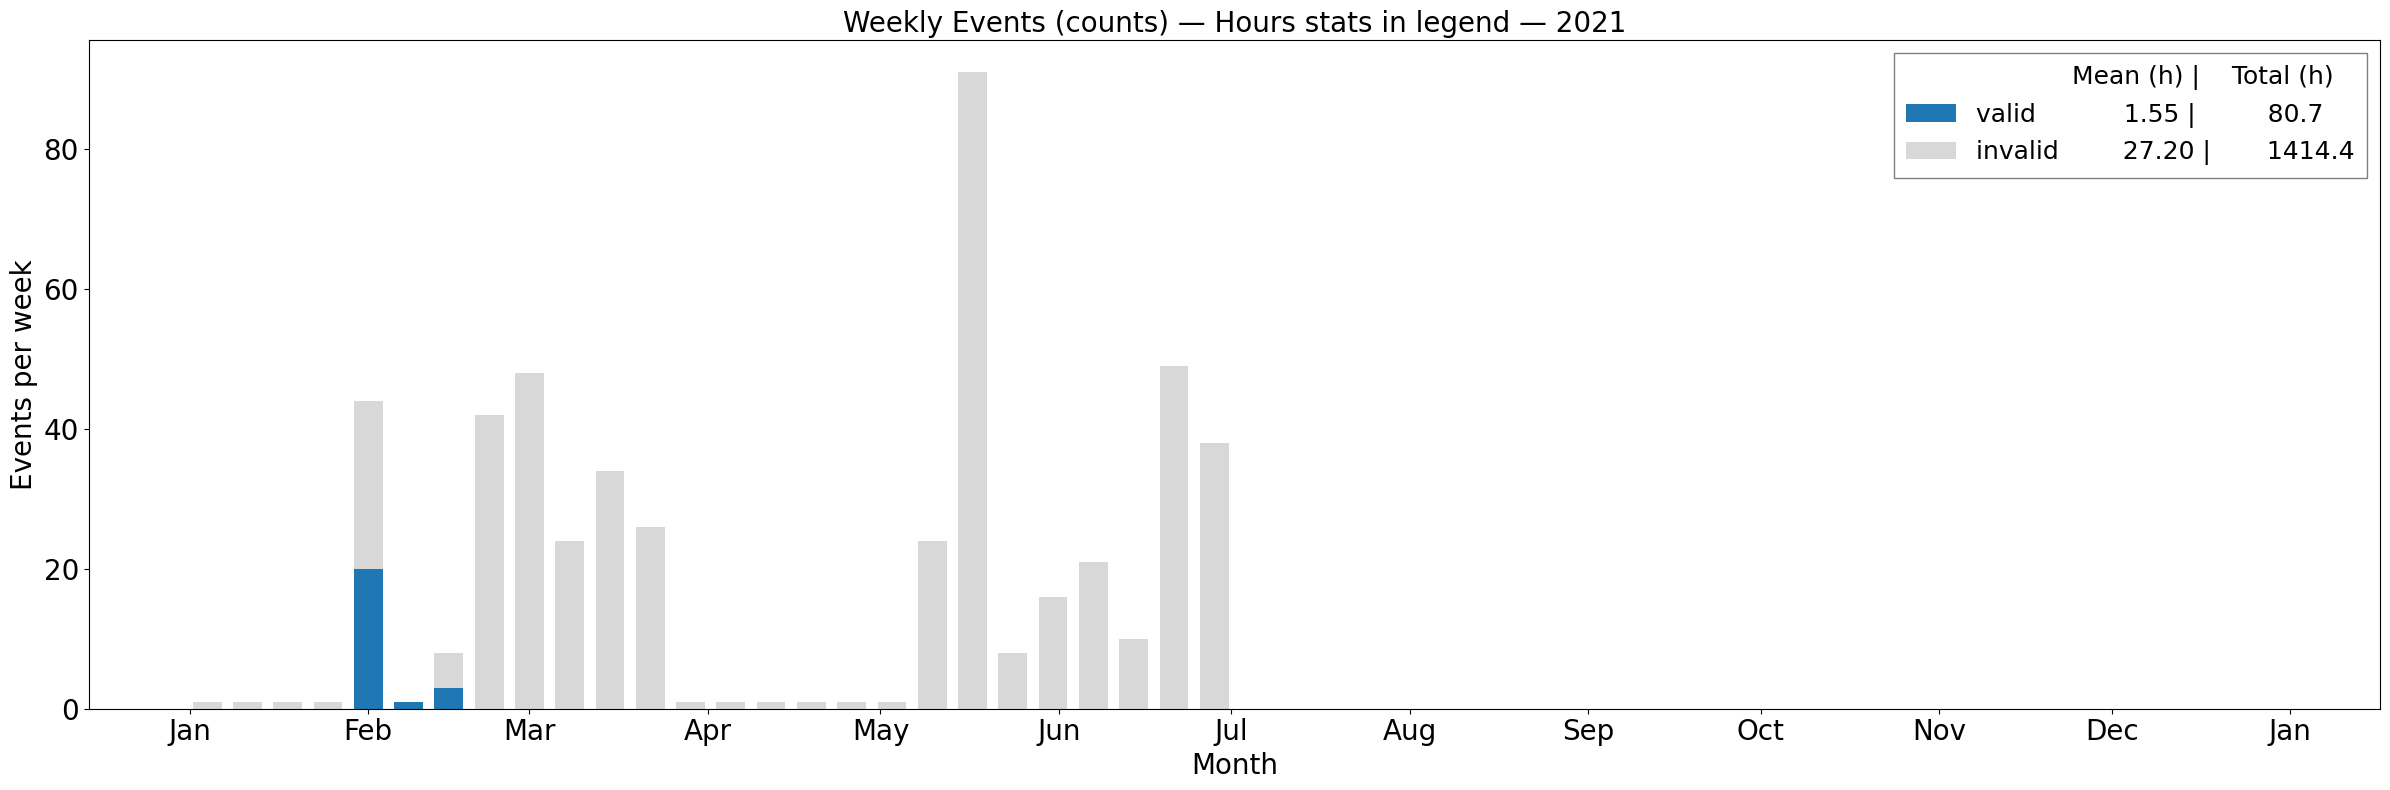

In [26]:
plot_weekly_valid_invalid_counts_from_clean(df_status)

In [27]:
df_status[(df_status['duration_hours']>24)&(df_status['is_valid']==True)]['duration_hours'].sum() # Hours that can be used to forecast the model in timeframes of 4, 6, 8 and 12

np.float64(8256.121944444445)

In [28]:
total_sum = df_status.loc[
    ((df_status['duration_hours'] > 24) & (~df_status['is_valid'])) |
    ((df_status['duration_hours'] < 24) & (~df_status['is_valid'])) |
    ((df_status['duration_hours'] < 24) & (df_status['is_valid'])),
    'duration_hours'
].sum()

total_sum # Hours that cannot be used

np.float64(18447.02555555556)

In [29]:
df_status[df_status['is_valid']==True].drop(columns=['is_valid', 'is_invalid'])

,start,end,duration_hours
2,2016-06-15 14:29:34,2016-06-15 14:31:22,0.030000
16,2016-06-17 08:49:48,2016-06-20 13:21:28,76.527778
17,2016-06-20 13:22:00,2016-06-22 08:42:01,43.333611
19,2016-06-22 08:59:25,2016-06-22 09:04:23,0.082778
21,2016-06-22 09:55:28,2016-06-22 15:30:13,5.579167
...,...,...,...
30581,2021-04-30 12:00:47,2021-04-30 12:04:33,0.062778
30582,2021-04-30 12:16:12,2021-04-30 17:47:48,5.526667
30644,2021-05-01 07:50:21,2021-05-01 08:32:16,0.698611
30648,2021-05-05 13:24:21,2021-05-05 13:45:24,0.350833


In [35]:
time_to_use = df_status[(df_status['duration_hours']>24)&(df_status['is_valid']==True)].drop(columns=['is_valid', 'is_invalid'])

In [36]:
time_to_use.count()

start             182
end               182
duration_hours    182
dtype: int64